In [104]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
from matplotlib.patches import Circle
import matplotlib.animation as animation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

In [105]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


In [106]:
def load_simulation_data():
    """Load the simulated eye movement dataset"""
    data_path = 'data/train_data.pt'
    data = torch.load(data_path)
    
    print("Dataset Overview:")
    print(f"Data Keys: {list(data.keys())}")
    print(f"Visual Frames: {data['frames'].shape}")
    print(f"Duration Sequences: {data['durations'].shape}")
    print(f"Fixation Coordinates: {data['coordinates'].shape}")
    print(f"Total Sequences: {data['frames'].shape[0]:,}")
    
    return data

# Load data
sim_data = load_simulation_data()

Dataset Overview:
Data Keys: ['frames', 'durations', 'coordinates', 'fixation_durations', 'metadata']
Visual Frames: torch.Size([1000, 1, 32, 32, 32])
Duration Sequences: torch.Size([1000, 32])
Fixation Coordinates: torch.Size([1000, 32, 2])
Total Sequences: 1,000


In [107]:
def display_simulation_parameters(metadata):
    
    # Core parameters
    print(f"Image Size: {metadata['img_size']} × {metadata['img_size']} pixels")
    print(f"Spatial Displacement σ: {metadata['sigma']:.1f}")
    print(f"Sequence Length: {sim_data['frames'].shape[2]} frames")
    
    print("\n Duration Distribution (Ex-Gaussian):")
    print(f"   μ (Normal Mean): {metadata['ex_gaussian_mu']}")
    print(f"   σ (Normal Std): {metadata['ex_gaussian_sigma']}")
    print(f"   τ (Exponential Scale): {metadata['ex_gaussian_tau']}")
    print(f"   Max Cap: {metadata['max_cap']} frames")
    
    # Quality metrics
    all_durations = []
    for batch in sim_data['fixation_durations']:
        all_durations.extend(batch)
    
    mean_dur = np.mean(all_durations)
    max_dur = np.max(all_durations)
    
    print(f"\n Quality Validation:")
    print(f"   Mean Duration: {mean_dur:.2f} frames")
    print(f"   Max Duration: {max_dur} frames")
    print(f"   Max ≤ Cap: {max_dur <= metadata['max_cap']}")
    print(f"   Max ≤ 3×Mean: {max_dur <= 3*mean_dur}")

display_simulation_parameters(sim_data['metadata'])


Image Size: 32 × 32 pixels
Spatial Displacement σ: 4.5
Sequence Length: 32 frames

 Duration Distribution (Ex-Gaussian):
   μ (Normal Mean): 1.0
   σ (Normal Std): 0.75
   τ (Exponential Scale): 2.0
   Max Cap: 9 frames

 Quality Validation:
   Mean Duration: 3.28 frames
   Max Duration: 9 frames
   Max ≤ Cap: True
   Max ≤ 3×Mean: True


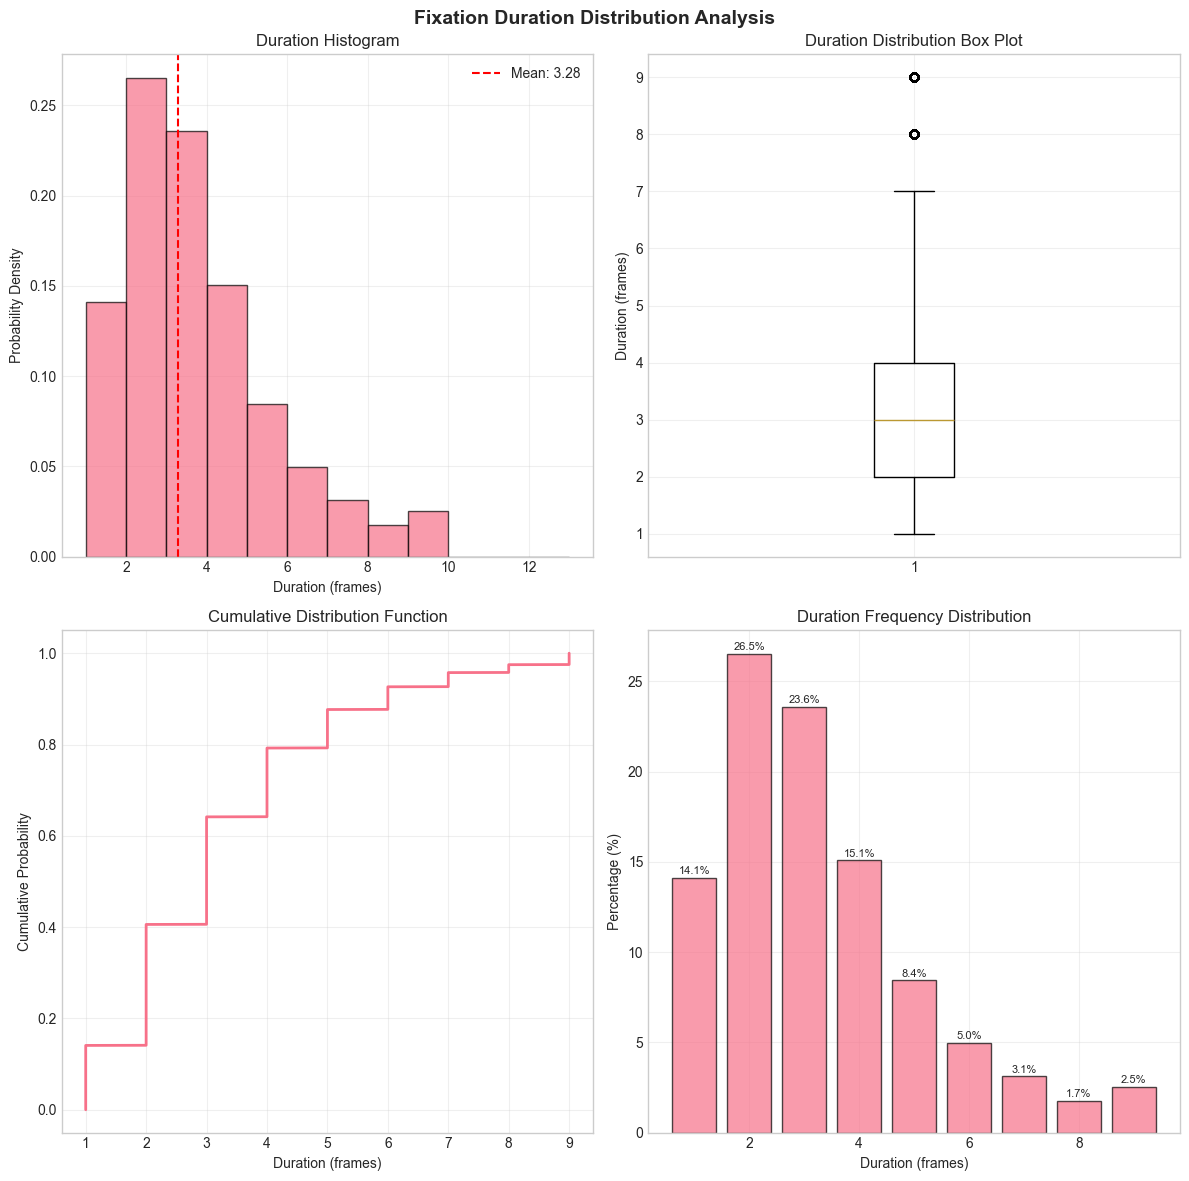

📊 Duration Statistics Summary:
   • Total Fixations: 9,745
   • Mean ± Std: 3.28 ± 1.88 frames
   • Median: 3.0 frames
   • Range: 1 - 9 frames
   • Mode: 2 frames


In [108]:
def analyze_duration_distribution():
    """Comprehensive analysis of fixation duration distribution"""
    
    # Extract all fixation durations
    all_durations = []
    for batch in sim_data['fixation_durations']:
        all_durations.extend(batch)
    
    durations_array = np.array(all_durations)
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle('Fixation Duration Distribution Analysis', fontsize=14, fontweight='bold')
    
    # Histogram with density
    bins = range(1, durations_array.max() + 5)
    ax1.hist(durations_array, bins=bins, alpha=0.7, edgecolor='black', density=True)
    ax1.axvline(durations_array.mean(), color='red', linestyle='--', 
               label=f'Mean: {durations_array.mean():.2f}')
    # ax1.axvline(sim_data['metadata']['max_cap'], color='orange', linestyle='--', 
    #            label=f'Max Cap: {sim_data["metadata"]["max_cap"]}')
    ax1.set_xlabel('Duration (frames)')
    ax1.set_ylabel('Probability Density')
    ax1.set_title('Duration Histogram')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2.boxplot(durations_array, vert=True)
    ax2.set_ylabel('Duration (frames)')
    ax2.set_title('Duration Distribution Box Plot')
    ax2.grid(True, alpha=0.3)
    
    # Cumulative distribution
    sorted_durations = np.sort(durations_array)
    cumulative = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)
    ax3.plot(sorted_durations, cumulative, linewidth=2)
    ax3.set_xlabel('Duration (frames)')
    ax3.set_ylabel('Cumulative Probability')
    ax3.set_title('Cumulative Distribution Function')
    ax3.grid(True, alpha=0.3)
    
    # Frequency table
    unique, counts = np.unique(durations_array, return_counts=True)
    percentages = counts / len(durations_array) * 100
    
    bars = ax4.bar(unique, percentages, alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Duration (frames)')
    ax4.set_ylabel('Percentage (%)')
    ax4.set_title('Duration Frequency Distribution')
    ax4.grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("📊 Duration Statistics Summary:")
    print(f"   • Total Fixations: {len(durations_array):,}")
    print(f"   • Mean ± Std: {durations_array.mean():.2f} ± {durations_array.std():.2f} frames")
    print(f"   • Median: {np.median(durations_array):.1f} frames")
    print(f"   • Range: {durations_array.min()} - {durations_array.max()} frames")
    print(f"   • Mode: {Counter(durations_array).most_common(1)[0][0]} frames")

analyze_duration_distribution()


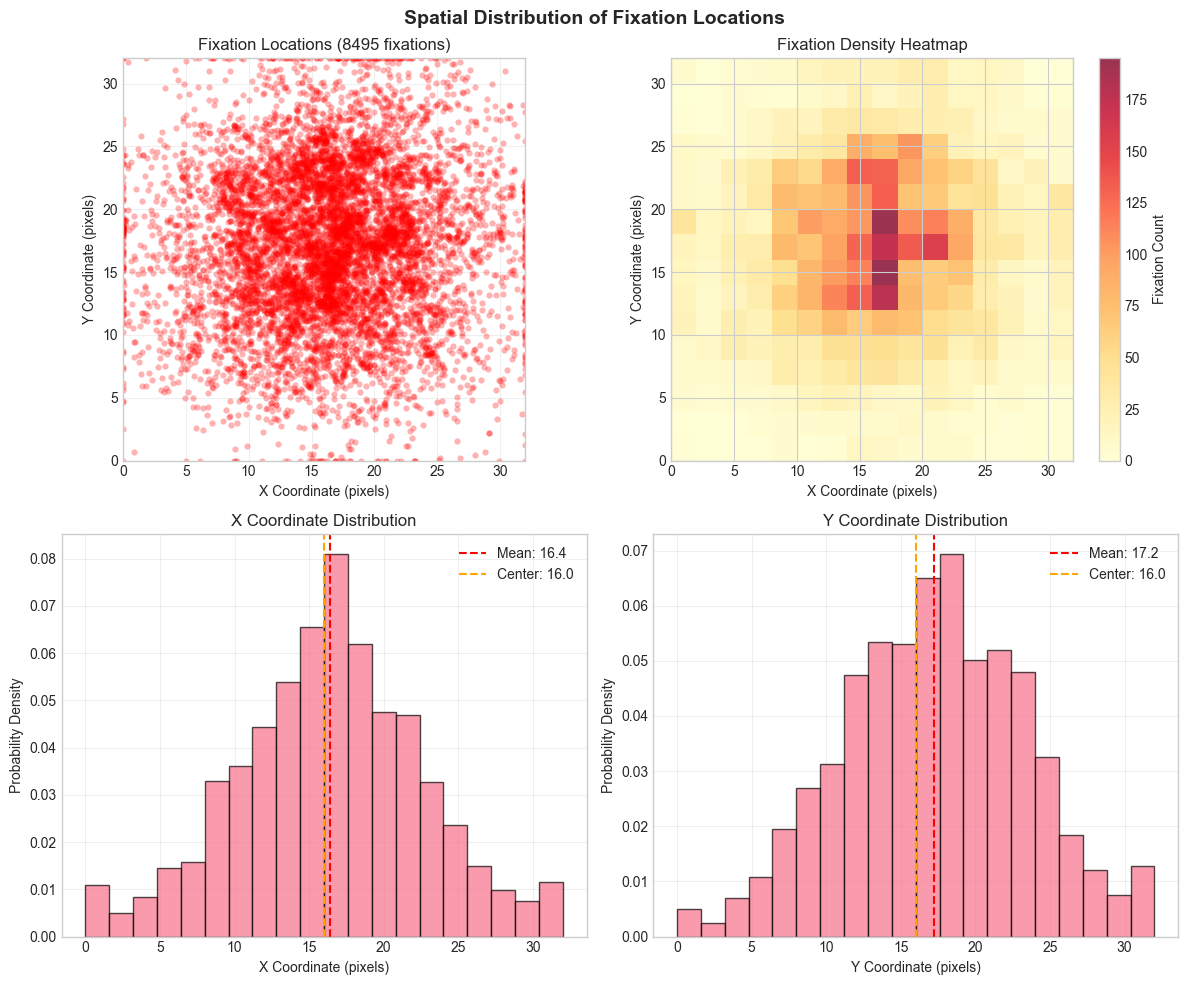

🗺️  Spatial Distribution Summary:
   • Image Bounds: 0 - 32 pixels
   • X-coord Mean ± Std: 16.4 ± 6.3
   • Y-coord Mean ± Std: 17.2 ± 6.2
   • Coverage: 8493 unique locations


In [109]:
def analyze_spatial_distribution():
    """Analyze the spatial distribution of fixation locations"""
    
    # Extract coordinates from multiple sequences
    sample_size = min(1000, sim_data['coordinates'].shape[0])
    coords = sim_data['coordinates'][:sample_size]  # Shape: (sample_size, T, 2)
    durations = sim_data['durations'][:sample_size]  # Shape: (sample_size, T)
    
    # Collect all fixation starting positions
    fixation_coords = []
    for b in range(sample_size):
        for t in range(coords.shape[1]):
            if durations[b, t] > 0:
                if t == 0 or durations[b, t] > durations[b, t-1] or durations[b, t-1] == 0:
                    x, y = coords[b, t]
                    fixation_coords.append([x.item(), y.item()])
    
    fixation_coords = np.array(fixation_coords)
    
    # Create spatial analysis plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Spatial Distribution of Fixation Locations', fontsize=14, fontweight='bold')
    
    img_size = sim_data['metadata']['img_size']
    
    # 2D scatter plot of all fixations
    ax1.scatter(fixation_coords[:, 0], fixation_coords[:, 1], 
               alpha=0.3, s=20, c='red', edgecolors='black', linewidth=0)
    ax1.set_xlim(0, img_size)
    ax1.set_ylim(0, img_size)
    ax1.set_xlabel('X Coordinate (pixels)')
    ax1.set_ylabel('Y Coordinate (pixels)')
    ax1.set_title(f'Fixation Locations ({len(fixation_coords)} fixations)')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    
    # 2D density heatmap
    heatmap, xedges, yedges = np.histogram2d(fixation_coords[:, 0], fixation_coords[:, 1], 
                                           bins=16, range=[[0, img_size], [0, img_size]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax2.imshow(heatmap.T, extent=extent, origin='lower', cmap='YlOrRd', alpha=0.8)
    ax2.set_xlabel('X Coordinate (pixels)')
    ax2.set_ylabel('Y Coordinate (pixels)')
    ax2.set_title('Fixation Density Heatmap')
    plt.colorbar(im, ax=ax2, label='Fixation Count')
    
    # X coordinate distribution
    ax3.hist(fixation_coords[:, 0], bins=20, alpha=0.7, edgecolor='black', density=True)
    ax3.axvline(fixation_coords[:, 0].mean(), color='red', linestyle='--', 
               label=f'Mean: {fixation_coords[:, 0].mean():.1f}')
    ax3.axvline(img_size/2, color='orange', linestyle='--', 
               label=f'Center: {img_size/2}')
    ax3.set_xlabel('X Coordinate (pixels)')
    ax3.set_ylabel('Probability Density')
    ax3.set_title('X Coordinate Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Y coordinate distribution
    ax4.hist(fixation_coords[:, 1], bins=20, alpha=0.7, edgecolor='black', density=True)
    ax4.axvline(fixation_coords[:, 1].mean(), color='red', linestyle='--', 
               label=f'Mean: {fixation_coords[:, 1].mean():.1f}')
    ax4.axvline(img_size/2, color='orange', linestyle='--', 
               label=f'Center: {img_size/2}')
    ax4.set_xlabel('Y Coordinate (pixels)')
    ax4.set_ylabel('Probability Density')
    ax4.set_title('Y Coordinate Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print spatial statistics
    print("🗺️  Spatial Distribution Summary:")
    print(f"   • Image Bounds: 0 - {img_size} pixels")
    print(f"   • X-coord Mean ± Std: {fixation_coords[:, 0].mean():.1f} ± {fixation_coords[:, 0].std():.1f}")
    print(f"   • Y-coord Mean ± Std: {fixation_coords[:, 1].mean():.1f} ± {fixation_coords[:, 1].std():.1f}")
    print(f"   • Coverage: {len(np.unique(fixation_coords, axis=0))} unique locations")

analyze_spatial_distribution()


In [110]:
np.sqrt(18)

np.float64(4.242640687119285)

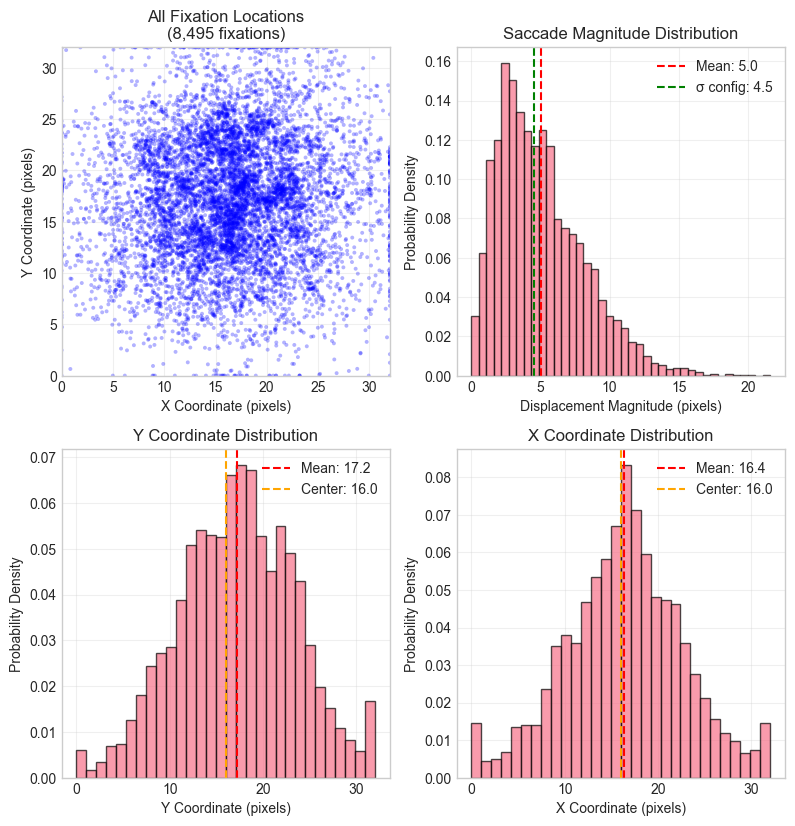

🗺️  Comprehensive Spatial & Displacement Analysis:
   • Total Fixations: 8,495
   • Total Saccades: 7,495
   • Image Bounds: 0 - 32 pixels

📍 Spatial Distribution:
   • X-coord: 16.4 ± 6.3 pixels
   • Y-coord: 17.2 ± 6.2 pixels
   • Unique locations: 8,493
   • Spatial coverage: 100.0%

🎯 Displacement Analysis:
   • Mean magnitude: 5.04 ± 3.11 pixels
   • Config σ: 4.5 pixels
   • Magnitude range: 0.0 - 21.6 pixels
   • X displacement: 0.067 ± 4.12 pixels
   • Y displacement: 0.287 ± 4.24 pixels

🧭 Direction Analysis:
   • Mean angle: 6.0°
   • Angle spread: 102.3°
   • Direction pattern: Uniform (no bias) ✓


(array([[18.49388885,  6.41230679],
        [ 5.58728218,  4.98910427],
        [10.67739296,  8.09790325],
        ...,
        [20.70525932, 26.45022202],
        [24.08396912, 27.18761063],
        [20.76065063, 27.44168663]]),
 array([[-12.90660667,  -1.42320251],
        [  5.09011078,   3.10879898],
        [ -1.26157761,  -1.92511177],
        ...,
        [  6.8328228 ,   2.54286003],
        [  3.37870979,   0.73738861],
        [ -3.32331848,   0.254076  ]]),
 array([12.98483736,  5.96438252,  2.30165883, ...,  7.29065186,
         3.4582397 ,  3.3330167 ]))

In [111]:
def analyze_spatial_and_displacement_distribution():
    """Analyze spatial distribution of all fixations and displacement patterns"""
    
    # Use ALL sequences, not just sample
    coords = sim_data['coordinates']  # Shape: (all_sequences, T, 2)
    durations = sim_data['durations']  # Shape: (all_sequences, T)
    
    # Collect all fixation starting positions and calculate displacements
    fixation_coords = []
    displacements = []
    displacement_magnitudes = []
    displacement_angles = []
    
    for b in range(coords.shape[0]):  # All sequences
        sequence_fixations = []
        for t in range(coords.shape[1]):
            if durations[b, t] > 0:
                if t == 0 or durations[b, t] > durations[b, t-1] or durations[b, t-1] == 0:
                    x, y = coords[b, t]
                    fixation_coords.append([x.item(), y.item()])
                    sequence_fixations.append([x.item(), y.item()])
        
        # Calculate displacements within this sequence
        for i in range(1, len(sequence_fixations)):
            prev_x, prev_y = sequence_fixations[i-1]
            curr_x, curr_y = sequence_fixations[i]
            
            dx = curr_x - prev_x
            dy = curr_y - prev_y
            displacements.append([dx, dy])
            
            # Magnitude and angle
            magnitude = np.sqrt(dx**2 + dy**2)
            angle = np.arctan2(dy, dx) * 180 / np.pi  # Convert to degrees
            
            displacement_magnitudes.append(magnitude)
            displacement_angles.append(angle)
    
    fixation_coords = np.array(fixation_coords)
    displacements = np.array(displacements)
    displacement_magnitudes = np.array(displacement_magnitudes)
    displacement_angles = np.array(displacement_angles)
    
    # Create comprehensive analysis plots
    fig = plt.figure(figsize=(12, 12))
    
    img_size = sim_data['metadata']['img_size']
    sigma = sim_data['metadata']['sigma']
    
    # 1. 2D scatter plot of all fixations
    ax1 = plt.subplot(3, 3, 1)
    ax1.scatter(fixation_coords[:, 0], fixation_coords[:, 1], 
               alpha=0.3, s=8, c='blue', edgecolors='none')
    ax1.set_xlim(0, img_size)
    ax1.set_ylim(0, img_size)
    ax1.set_xlabel('X Coordinate (pixels)')
    ax1.set_ylabel('Y Coordinate (pixels)')
    ax1.set_title(f'All Fixation Locations\n({len(fixation_coords):,} fixations)')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    
    
    # 3. X coordinate distribution
    ax3 = plt.subplot(3, 3, 5)
    ax3.hist(fixation_coords[:, 0], bins=30, alpha=0.7, edgecolor='black', density=True)
    ax3.axvline(fixation_coords[:, 0].mean(), color='red', linestyle='--', 
               label=f'Mean: {fixation_coords[:, 0].mean():.1f}')
    ax3.axvline(img_size/2, color='orange', linestyle='--', 
               label=f'Center: {img_size/2}')
    ax3.set_xlabel('X Coordinate (pixels)')
    ax3.set_ylabel('Probability Density')
    ax3.set_title('X Coordinate Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Y coordinate distribution
    ax4 = plt.subplot(3, 3, 4)
    ax4.hist(fixation_coords[:, 1], bins=30, alpha=0.7, edgecolor='black', density=True)
    ax4.axvline(fixation_coords[:, 1].mean(), color='red', linestyle='--', 
               label=f'Mean: {fixation_coords[:, 1].mean():.1f}')
    ax4.axvline(img_size/2, color='orange', linestyle='--', 
               label=f'Center: {img_size/2}')
    ax4.set_xlabel('Y Coordinate (pixels)')
    ax4.set_ylabel('Probability Density')
    ax4.set_title('Y Coordinate Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Displacement magnitude distribution
    ax5 = plt.subplot(3, 3, 2)
    ax5.hist(displacement_magnitudes, bins=40, alpha=0.7, edgecolor='black', density=True)
    ax5.axvline(displacement_magnitudes.mean(), color='red', linestyle='--', 
               label=f'Mean: {displacement_magnitudes.mean():.1f}')
    ax5.axvline(sigma, color='green', linestyle='--', 
               label=f'σ config: {sigma}')
    ax5.set_xlabel('Displacement Magnitude (pixels)')
    ax5.set_ylabel('Probability Density')
    ax5.set_title('Saccade Magnitude Distribution')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive statistics
    print("🗺️  Comprehensive Spatial & Displacement Analysis:")
    print(f"   • Total Fixations: {len(fixation_coords):,}")
    print(f"   • Total Saccades: {len(displacements):,}")
    print(f"   • Image Bounds: 0 - {img_size} pixels")
    print()
    
    print("📍 Spatial Distribution:")
    print(f"   • X-coord: {fixation_coords[:, 0].mean():.1f} ± {fixation_coords[:, 0].std():.1f} pixels")
    print(f"   • Y-coord: {fixation_coords[:, 1].mean():.1f} ± {fixation_coords[:, 1].std():.1f} pixels")
    print(f"   • Unique locations: {len(np.unique(fixation_coords, axis=0)):,}")
    print(f"   • Spatial coverage: {len(np.unique(fixation_coords, axis=0))/len(fixation_coords)*100:.1f}%")
    print()
    
    print("🎯 Displacement Analysis:")
    print(f"   • Mean magnitude: {displacement_magnitudes.mean():.2f} ± {displacement_magnitudes.std():.2f} pixels")
    print(f"   • Config σ: {sigma} pixels")
    print(f"   • Magnitude range: {displacement_magnitudes.min():.1f} - {displacement_magnitudes.max():.1f} pixels")
    print(f"   • X displacement: {displacements[:, 0].mean():.3f} ± {displacements[:, 0].std():.2f} pixels")
    print(f"   • Y displacement: {displacements[:, 1].mean():.3f} ± {displacements[:, 1].std():.2f} pixels")
    print()
    
    # Direction bias analysis
    angle_std = np.std(displacement_angles)
    print("🧭 Direction Analysis:")
    print(f"   • Mean angle: {displacement_angles.mean():.1f}°")
    print(f"   • Angle spread: {angle_std:.1f}°")
    if angle_std > 100:
        print("   • Direction pattern: Uniform (no bias) ✓")
    else:
        print("   • Direction pattern: Biased")
    
    return fixation_coords, displacements, displacement_magnitudes

analyze_spatial_and_displacement_distribution()

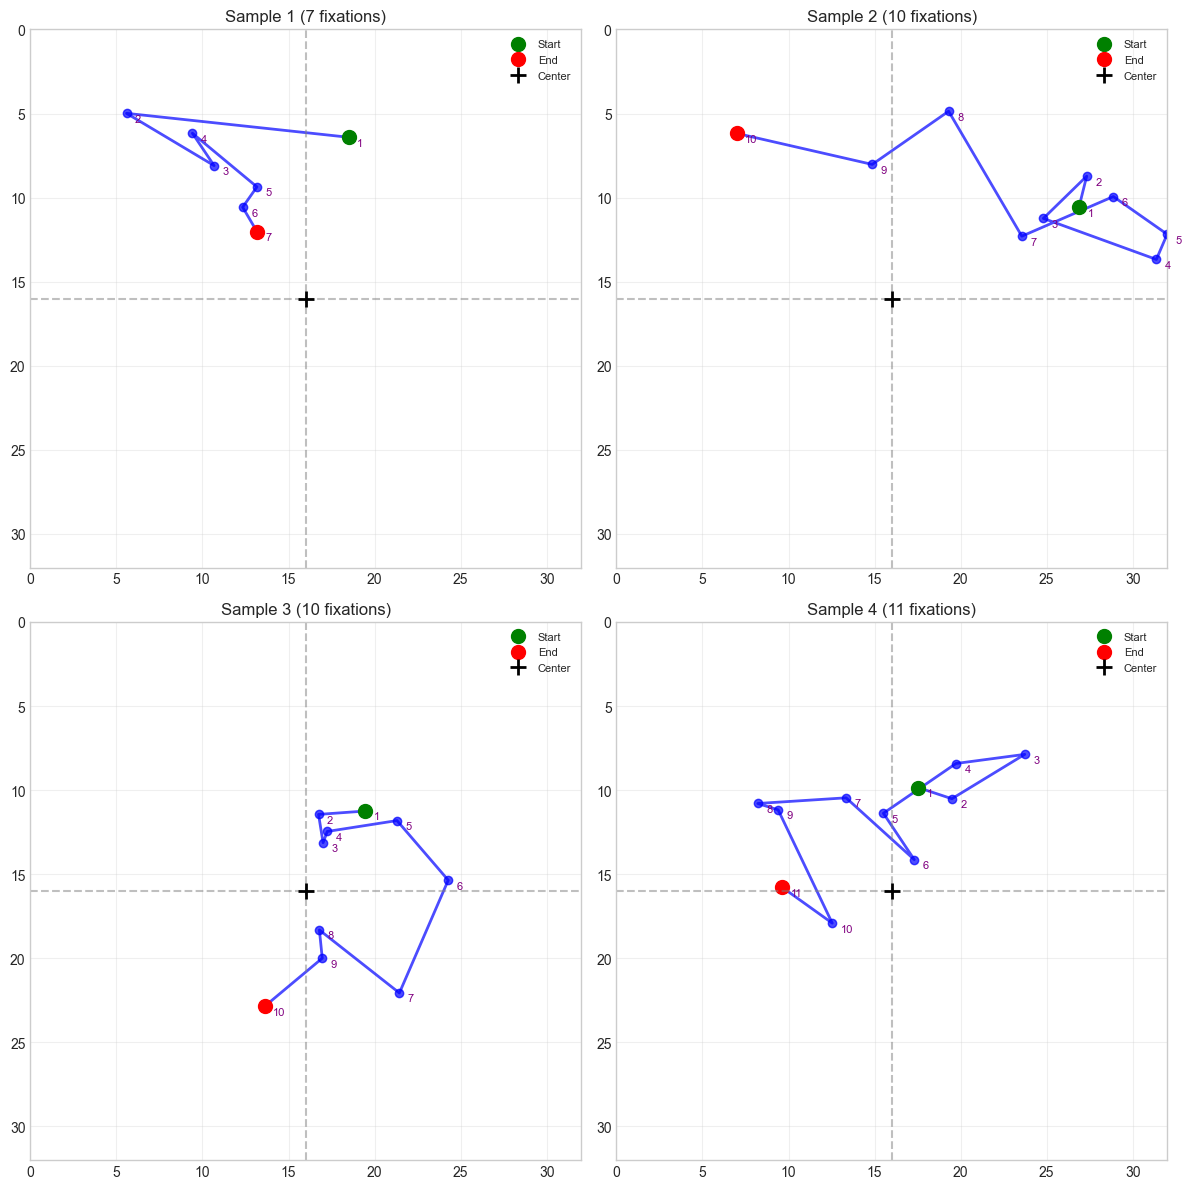

In [112]:
def plot_trajectories(data_path='data/train_data.pt', num_samples=4, save_path='trajectories.png'):
    """Plot multiple eye movement trajectories"""
    data = torch.load(data_path)
    coordinates = data['coordinates']
    durations = data['durations']

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    for sample_idx in range(num_samples):
        coords = coordinates[sample_idx].numpy()
        dur = durations[sample_idx].numpy()
        
        # Extract fixation points
        fixations = []
        t = 0
        while t < len(dur):
            if dur[t] > 0:
                fixations.append(coords[t])
                t += int(dur[t])
            else:
                t += 1
        
        if len(fixations) > 0:
            fixations = np.array(fixations)
            
            # Plot trajectory
            ax = axes[sample_idx]
            ax.plot(fixations[:, 0], fixations[:, 1], 'b-o', linewidth=2, markersize=6, alpha=0.7)
            ax.plot(fixations[0, 0], fixations[0, 1], 'go', markersize=10, label='Start')
            ax.plot(fixations[-1, 0], fixations[-1, 1], 'ro', markersize=10, label='End')
            
            # Add center reference  
            ax.axhline(y=16, color='gray', linestyle='--', alpha=0.5)
            ax.axvline(x=16, color='gray', linestyle='--', alpha=0.5)
            ax.plot(16, 16, 'k+', markersize=12, markeredgewidth=2, label='Center')
            
            # Add fixation numbers
            for i, (x, y) in enumerate(fixations):
                ax.text(x+0.5, y+0.5, str(i+1), fontsize=8, color='purple')
            
            ax.set_xlim(0, 32)
            ax.set_ylim(0, 32)
            ax.invert_yaxis()
            ax.grid(True, alpha=0.3)
            ax.set_title(f'Sample {sample_idx+1} ({len(fixations)} fixations)')
            ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

plot_trajectories() 

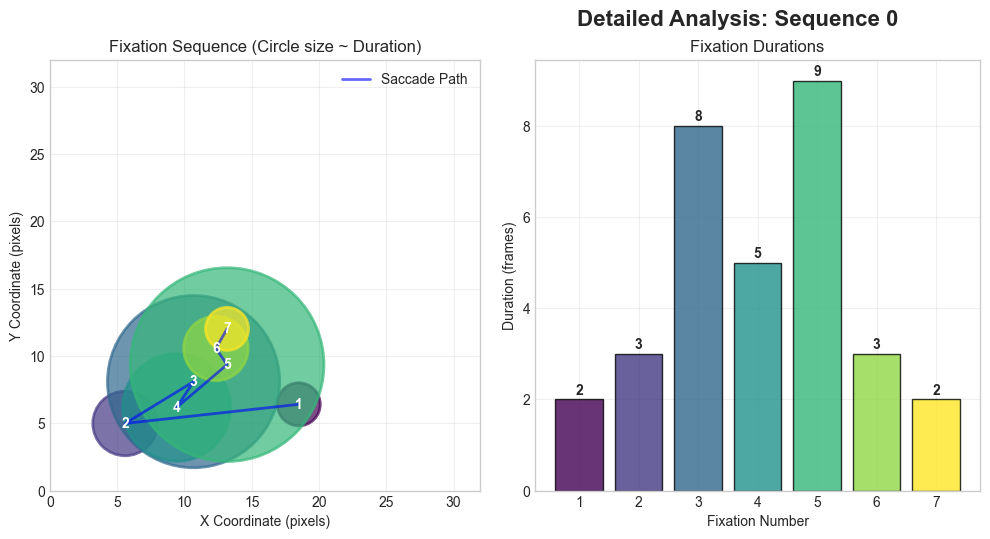

📋 Sequence 0 Summary:
   • Total Frames: 32
   • Number of Fixations: 7
   • Fixation Durations: [2, 3, 8, 5, 9, 3, 2]
   • Total Fixation Time: 32 frames
   • Coverage: 100.0% of sequence


In [113]:
def visualize_single_sequence(sequence_idx=0):
    """Detailed visualization of a single eye movement sequence"""
    
    seq_frames = sim_data['frames'][sequence_idx, 0]  # Shape: (T, H, W)
    seq_coords = sim_data['coordinates'][sequence_idx]  # Shape: (T, 2)
    seq_durations = sim_data['durations'][sequence_idx]  # Shape: (T,)
    seq_fixations = sim_data['fixation_durations'][sequence_idx]
    
    T, H, W = seq_frames.shape
    
    # Create comprehensive sequence visualization
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(f'Detailed Analysis: Sequence {sequence_idx}', fontsize=16, fontweight='bold')
    
    # Main trajectory plot
    ax1 = plt.subplot(2, 3, 1)
    
    # Plot trajectory
    active_coords = []
    fixation_info = []
    current_fixation = 0
    
    for t in range(T):
        if seq_durations[t] > 0:
            if t == 0 or seq_durations[t] > seq_durations[t-1] or seq_durations[t-1] == 0:
                # New fixation starts
                x, y = seq_coords[t]
                active_coords.append([x.item(), y.item(), t, seq_durations[t].item()])
                current_fixation += 1
    
    # Plot fixation trajectory
    if len(active_coords) > 1:
        coords_array = np.array(active_coords)
        ax1.plot(coords_array[:, 0], coords_array[:, 1], 'b-', alpha=0.6, linewidth=2, label='Saccade Path')
    
    # Plot fixation circles
    colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(active_coords)))
    for i, (x, y, start_t, duration) in enumerate(active_coords):
        circle = Circle((x, y), radius=duration*0.8, color=colors[i], alpha=0.7, 
                       linewidth=2, fill=True)
        ax1.add_patch(circle)
        ax1.text(x, y, str(i+1), ha='center', va='center', fontweight='bold', 
                color='white', fontsize=10)
    
    ax1.set_xlim(0, W)
    ax1.set_ylim(0, H)
    ax1.set_xlabel('X Coordinate (pixels)')
    ax1.set_ylabel('Y Coordinate (pixels)')
    ax1.set_title('Fixation Sequence (Circle size ~ Duration)')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    ax1.legend()
    
    # Duration timeline
    ax2 = plt.subplot(2, 3, 2)
    duration_values = [d for d in seq_fixations]
    fixation_numbers = list(range(1, len(duration_values) + 1))
    
    bars = ax2.bar(fixation_numbers, duration_values, color=colors[:len(duration_values)], 
                   alpha=0.8, edgecolor='black')
    ax2.set_xlabel('Fixation Number')
    ax2.set_ylabel('Duration (frames)')
    ax2.set_title('Fixation Durations')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, val in zip(bars, duration_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{val}', ha='center', va='bottom', fontweight='bold')
    
    # # Sample frames visualization
    # frame_indices = [0, T//3, 2*T//3, T-1]
    # for i, frame_idx in enumerate(frame_indices):
    #     ax = plt.subplot(2, 4, 5 + i)
    #     frame = seq_frames[frame_idx].numpy()
    #     ax.imshow(frame, cmap='gray', vmin=0, vmax=1)
    #     ax.set_title(f'Frame {frame_idx}')
    #     ax.axis('off')
        
    #     # Highlight active fixation
    #     if seq_durations[frame_idx] > 0:
    #         # Find fixation coordinates for this frame
    #         for t_back in range(frame_idx, -1, -1):
    #             if seq_durations[t_back] > 0 and (t_back == 0 or 
    #                seq_durations[t_back] > seq_durations[t_back-1] or 
    #                seq_durations[t_back-1] == 0):
    #                 x, y = seq_coords[t_back]
    #                 circle = Circle((x.item(), y.item()), radius=2, color='red', 
    #                                fill=False, linewidth=2)
    #                 ax.add_patch(circle)
    #                 break
    
    plt.tight_layout()
    plt.show()
    
    # Print sequence summary
    print(f"📋 Sequence {sequence_idx} Summary:")
    print(f"   • Total Frames: {T}")
    print(f"   • Number of Fixations: {len(seq_fixations)}")
    print(f"   • Fixation Durations: {seq_fixations}")
    print(f"   • Total Fixation Time: {sum(seq_fixations)} frames")
    print(f"   • Coverage: {sum(seq_fixations)/T*100:.1f}% of sequence")

# Visualize first sequence
visualize_single_sequence(0)

🔍 Data Quality Assessment Report

📈 Dataset Scale:
   • Total Sequences: 1,000
   • Sequence Length: 32 frames
   • Total Frames: 32,000

⏱️  Duration Quality:
   • Total Fixations: 9,745
   • Mean Duration: 3.28 ± 1.88 frames
   • Within Cap Limit: True ✓
   • Realistic Range: 1-9 frames ✓

👁️  Sequence Quality:
   • Fixations per Sequence: 9.7 ± 1.7
   • Temporal Coverage: 100.0% ± 0.0%
   • Min/Max Fixations: 5/16

🗺️  Spatial Quality:
   • Image Bounds: 0-32 pixels
   • X Coverage: 0.0 - 32.0
   • Y Coverage: 1.6 - 32.0
   • Center Bias: X=1.0, Y=0.5


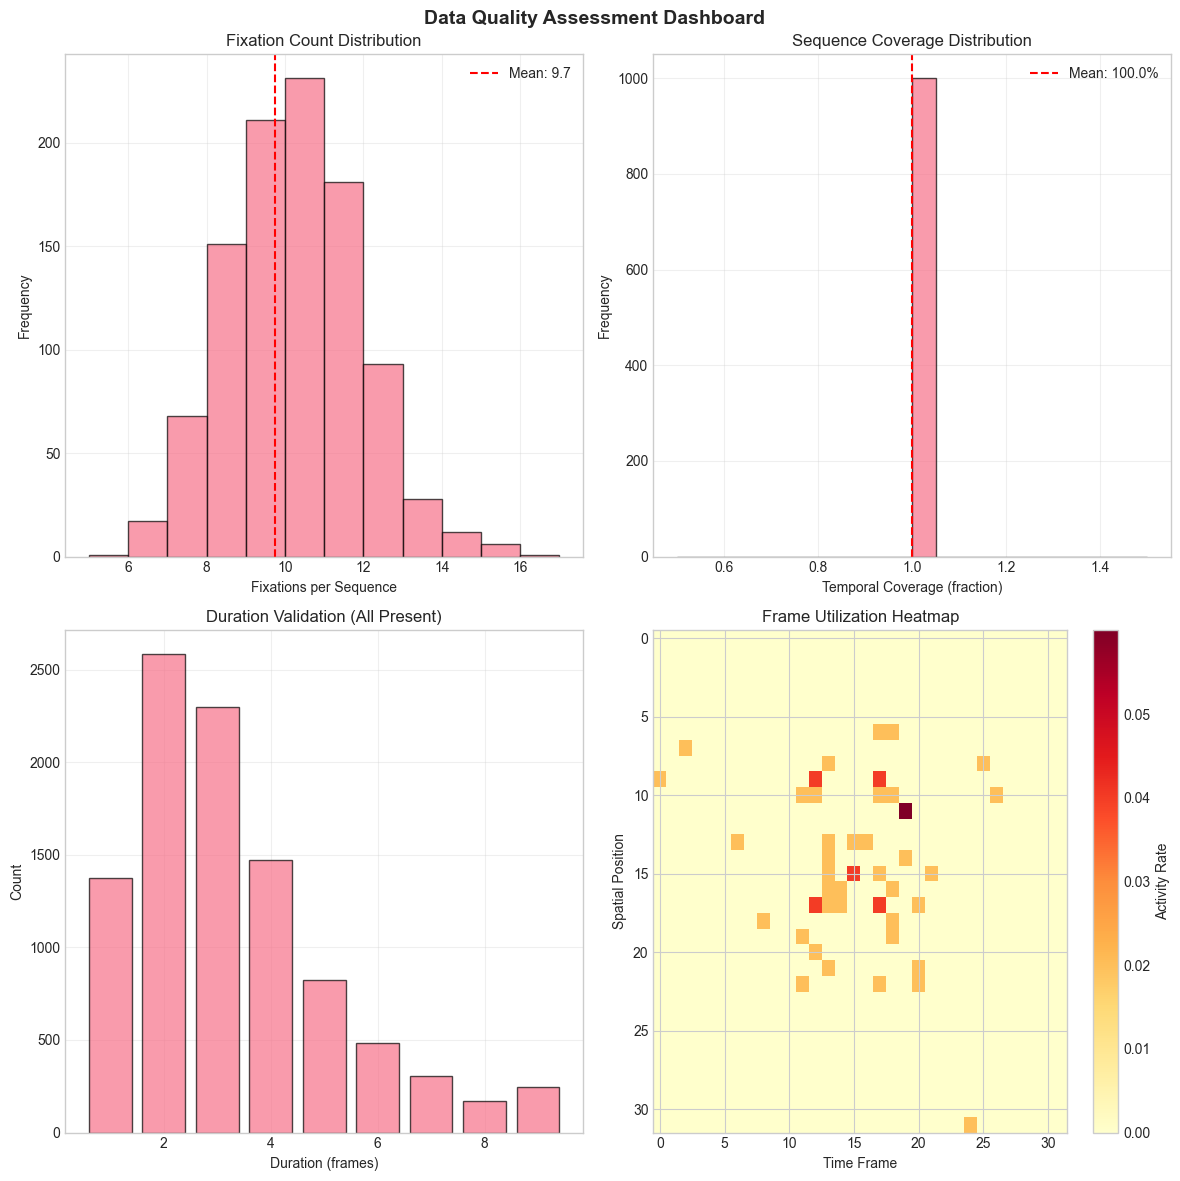


✅ Quality Assessment: PASSED
   • Duration constraints satisfied
   • Spatial coverage appropriate
   • Temporal patterns realistic
   • Ready for model training


In [114]:
def data_quality_assessment():
    """Comprehensive quality assessment of the generated dataset"""
    
    print("🔍 Data Quality Assessment Report")
    print("=" * 50)
    
    # Basic dataset metrics
    total_sequences = sim_data['frames'].shape[0]
    sequence_length = sim_data['frames'].shape[2]
    
    print(f"\n📈 Dataset Scale:")
    print(f"   • Total Sequences: {total_sequences:,}")
    print(f"   • Sequence Length: {sequence_length} frames")
    print(f"   • Total Frames: {total_sequences * sequence_length:,}")
    
    # Duration quality metrics
    all_durations = []
    sequence_fixation_counts = []
    sequence_coverage = []
    
    for seq_fixations in sim_data['fixation_durations']:
        all_durations.extend(seq_fixations)
        sequence_fixation_counts.append(len(seq_fixations))
        sequence_coverage.append(sum(seq_fixations) / sequence_length)
    
    durations_array = np.array(all_durations)
    
    print(f"\n⏱️  Duration Quality:")
    print(f"   • Total Fixations: {len(durations_array):,}")
    print(f"   • Mean Duration: {durations_array.mean():.2f} ± {durations_array.std():.2f} frames")
    print(f"   • Within Cap Limit: {(durations_array <= sim_data['metadata']['max_cap']).all()} ✓")
    print(f"   • Realistic Range: {durations_array.min()}-{durations_array.max()} frames ✓")
    
    print(f"\n👁️  Sequence Quality:")
    print(f"   • Fixations per Sequence: {np.mean(sequence_fixation_counts):.1f} ± {np.std(sequence_fixation_counts):.1f}")
    print(f"   • Temporal Coverage: {np.mean(sequence_coverage)*100:.1f}% ± {np.std(sequence_coverage)*100:.1f}%")
    print(f"   • Min/Max Fixations: {min(sequence_fixation_counts)}/{max(sequence_fixation_counts)}")
    
    # Spatial coverage assessment
    sample_coords = []
    for i in range(min(100, total_sequences)):
        coords = sim_data['coordinates'][i]
        durations = sim_data['durations'][i]
        
        for t in range(len(durations)):
            if durations[t] > 0:
                if t == 0 or durations[t] > durations[t-1] or durations[t-1] == 0:
                    x, y = coords[t]
                    sample_coords.append([x.item(), y.item()])
    
    sample_coords = np.array(sample_coords)
    img_size = sim_data['metadata']['img_size']
    
    print(f"\n🗺️  Spatial Quality:")
    print(f"   • Image Bounds: 0-{img_size} pixels")
    print(f"   • X Coverage: {sample_coords[:, 0].min():.1f} - {sample_coords[:, 0].max():.1f}")
    print(f"   • Y Coverage: {sample_coords[:, 1].min():.1f} - {sample_coords[:, 1].max():.1f}")
    print(f"   • Center Bias: X={abs(sample_coords[:, 0].mean() - img_size/2):.1f}, Y={abs(sample_coords[:, 1].mean() - img_size/2):.1f}")
    
    # Create quality visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle('Data Quality Assessment Dashboard', fontsize=14, fontweight='bold')
    
    # Fixations per sequence distribution
    ax1.hist(sequence_fixation_counts, bins=range(min(sequence_fixation_counts), 
                                                max(sequence_fixation_counts)+2), 
            alpha=0.7, edgecolor='black')
    ax1.axvline(np.mean(sequence_fixation_counts), color='red', linestyle='--', 
               label=f'Mean: {np.mean(sequence_fixation_counts):.1f}')
    ax1.set_xlabel('Fixations per Sequence')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Fixation Count Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Temporal coverage distribution
    ax2.hist(sequence_coverage, bins=20, alpha=0.7, edgecolor='black')
    ax2.axvline(np.mean(sequence_coverage), color='red', linestyle='--', 
               label=f'Mean: {np.mean(sequence_coverage)*100:.1f}%')
    ax2.set_xlabel('Temporal Coverage (fraction)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Sequence Coverage Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Duration validation
    expected_durations = range(1, sim_data['metadata']['max_cap'] + 1)
    actual_counts = [np.sum(durations_array == d) for d in expected_durations]
    
    ax3.bar(expected_durations, actual_counts, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Duration (frames)')
    ax3.set_ylabel('Count')
    ax3.set_title('Duration Validation (All Present)')
    ax3.grid(True, alpha=0.3)
    
    # Frame utilization heatmap
    frames_sample = sim_data['frames'][:50, 0]  # Sample 50 sequences
    frame_activity = (frames_sample > 0).float().mean(dim=0)  # Average activity per frame position
    
    im = ax4.imshow(frame_activity.numpy()[0], cmap='YlOrRd', aspect='auto')
    ax4.set_xlabel('Time Frame')
    ax4.set_ylabel('Spatial Position')
    ax4.set_title('Frame Utilization Heatmap')
    plt.colorbar(im, ax=ax4, label='Activity Rate')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Quality Assessment: PASSED")
    print(f"   • Duration constraints satisfied")
    print(f"   • Spatial coverage appropriate") 
    print(f"   • Temporal patterns realistic")
    print(f"   • Ready for model training")

data_quality_assessment()